In [265]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

B2.1a

In [7]:
#set randan seed
torch.manual_seed(200205854)
#set batch size
batchSize = 4
#set transfrom
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])])

#Load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
#Load the test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Training set size: 60000
Test set size: 10000


Ankle boot T-shirt/top T-shirt/top      Dress


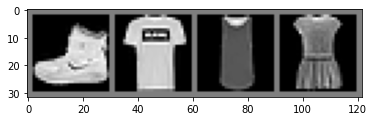

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap="gray") #rearrange dimensions to numpy format for disply
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #Get one batch (4 here)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(batchSize)))

B2.2b

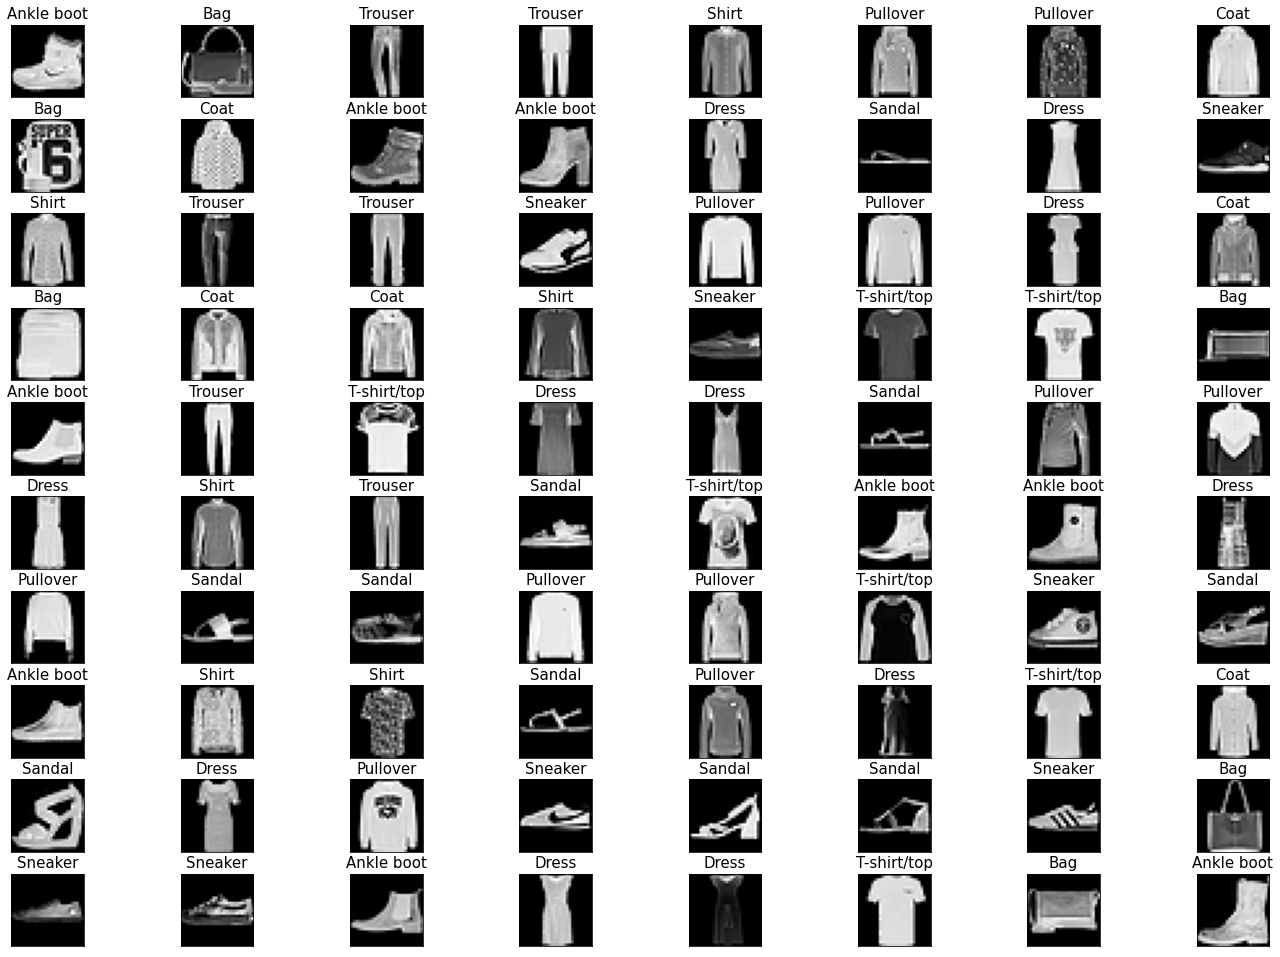

In [9]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=int(60000/80),
                                          shuffle=False, num_workers=2)
plt.subplots_adjust(left=0.5,
                    bottom=0.4, 
                    right=3.6, 
                    top=3.6, 
                    wspace=0.1, 
                    hspace=0.3)
def matplotlib_multi_pic1():
    i = 0
    for image, label in dataloader:
        i = i+1
        img = image[0]
        title=classes[label[0]]
        plt.subplot(10,8,i)
        imshow(img)
        plt.title(title,fontsize=15)
        plt.xticks([])
        plt.yticks([])
    plt.show()
matplotlib_multi_pic1()

In [252]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(28*28,10)
        self.sm = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.lr(x)
        x = self.sm(x)
        return x

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(lr.parameters(), lr=0.005)

In [268]:
def train_lr_model(lr,b):
    max_epochs = 6
    #torch.cuda.synchronize()
    start = time.time()
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i,(images, labels) in enumerate(trainloader):
            images = images
            labels = labels
            
            lr.zero_grad()
        
            output = criterion(lr(images), labels)
            l1_regularization, l2_regularization = torch.tensor([0], dtype=torch.float32), torch.tensor([0],dtype=torch.float32)  # 定义L1及L2正则化损失
            if(b == 'l1'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,1)  # L2 正则化
                output = output + 10e-5 * l1_regularization
            elif(b == 'l2'):
                for param in lr.parameters():
                    l2_regularization += torch.norm(param,2)  # L2 正则化
                output = output + 10e-3 * l2_regularization
            elif(b == "n"):
                outpur = output
            loss =output.item()
        
            output.backward()
        
            # Apply gradients
            for param in lr.parameters():
                param.data.add_(-0.5 * param.grad.data)

            # Stop criterion
            if loss < 1e-3:
                break
            running_loss += loss
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    #torch.cuda.synchronize()
    end = time.time()
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in lr.parameters())
    print("Total number of paramerters in LogristicRegression is {}".format(num_params))
    return (end-start), num_params

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.title('confusion matrix', fontsize = 20)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=0.5,  cbar=True, ax=ax, cmap='Blues',square=True)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [256]:
# test the model
def test_model(model):
    correct = 0
    total = 0
    y_pred = []
    y = []
    for images, labels in trainloader:
        images= images
        labels =labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_trainset = (100 * correct / total)
    print('accuracy of the model on training dataset %.2f' % accuracy_in_trainset)
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted
        y += labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy_in_testset = (100 * correct / total)
    print('accuracy of the model on test dataset %.2f' % (100 * correct / total))
    plot_confusion_matrix(y_pred, y)
    return accuracy_in_trainset, accuracy_in_testset
    

[1,  2000] loss: 1.687647
[1,  4000] loss: 1.639610
[1,  6000] loss: 1.628736
[1,  8000] loss: 1.617857
[1, 10000] loss: 1.616182
[1, 12000] loss: 1.607558
[1, 14000] loss: 1.606993
[2,  2000] loss: 1.602431
[2,  4000] loss: 1.600423
[2,  6000] loss: 1.598147
[2,  8000] loss: 1.596698
[2, 10000] loss: 1.596766
[2, 12000] loss: 1.592111
[2, 14000] loss: 1.596013
[3,  2000] loss: 1.592372
[3,  4000] loss: 1.591551
[3,  6000] loss: 1.588587
[3,  8000] loss: 1.590067
[3, 10000] loss: 1.591136
[3, 12000] loss: 1.585392
[3, 14000] loss: 1.589788
[4,  2000] loss: 1.587417
[4,  4000] loss: 1.584475
[4,  6000] loss: 1.584742
[4,  8000] loss: 1.585478
[4, 10000] loss: 1.586208
[4, 12000] loss: 1.581984
[4, 14000] loss: 1.583842
[5,  2000] loss: 1.585899
[5,  4000] loss: 1.580794
[5,  6000] loss: 1.579677
[5,  8000] loss: 1.581260
[5, 10000] loss: 1.580579
[5, 12000] loss: 1.581380
[5, 14000] loss: 1.581553
[6,  2000] loss: 1.581190
[6,  4000] loss: 1.580098
[6,  6000] loss: 1.581078
[6,  8000] l

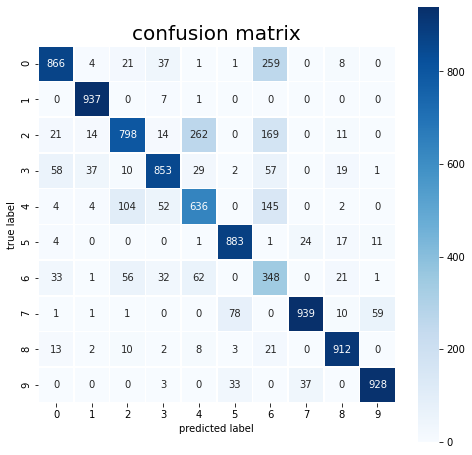

In [269]:
lr1 = LogisticRegression()
time_lr1, num_params_lr1 = train_lr_model(lr1,'n') # no regularization
accuracy_trainset_lr1, accuracy_testset_lr1 = test_model(lr1)

[1,  2000] loss: 1.694813
[1,  4000] loss: 1.636249
[1,  6000] loss: 1.629571
[1,  8000] loss: 1.621177
[1, 10000] loss: 1.616888
[1, 12000] loss: 1.607783
[1, 14000] loss: 1.610834
[2,  2000] loss: 1.602879
[2,  4000] loss: 1.599345
[2,  6000] loss: 1.595025
[2,  8000] loss: 1.597051
[2, 10000] loss: 1.595127
[2, 12000] loss: 1.592921
[2, 14000] loss: 1.596580
[3,  2000] loss: 1.592789
[3,  4000] loss: 1.592273
[3,  6000] loss: 1.589732
[3,  8000] loss: 1.590013
[3, 10000] loss: 1.589227
[3, 12000] loss: 1.585425
[3, 14000] loss: 1.588376
[4,  2000] loss: 1.588824
[4,  4000] loss: 1.585814
[4,  6000] loss: 1.584179
[4,  8000] loss: 1.586619
[4, 10000] loss: 1.584798
[4, 12000] loss: 1.584147
[4, 14000] loss: 1.585975
[5,  2000] loss: 1.584621
[5,  4000] loss: 1.582622
[5,  6000] loss: 1.582185
[5,  8000] loss: 1.582256
[5, 10000] loss: 1.580132
[5, 12000] loss: 1.580722
[5, 14000] loss: 1.582561
[6,  2000] loss: 1.582698
[6,  4000] loss: 1.579344
[6,  6000] loss: 1.579787
[6,  8000] l

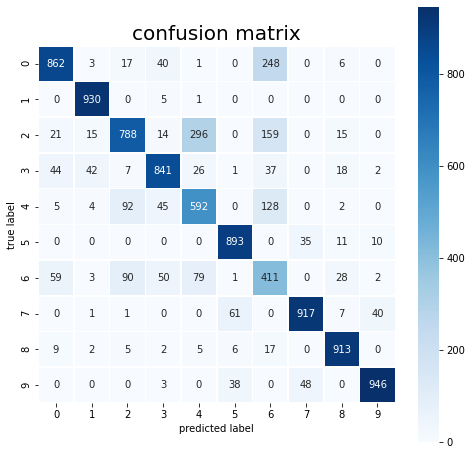

In [270]:
lr2 = LogisticRegression()
time_lr2, num_params_lr2 = train_lr_model(lr2, 'l1') # l1_regularization
accuracy_trainset_lr2, accuracy_testset_lr2 = test_model(lr2)

[1,  2000] loss: 1.786829
[1,  4000] loss: 1.756685
[1,  6000] loss: 1.761687
[1,  8000] loss: 1.757600
[1, 10000] loss: 1.757182
[1, 12000] loss: 1.754472
[1, 14000] loss: 1.754507
[2,  2000] loss: 1.757915
[2,  4000] loss: 1.754827
[2,  6000] loss: 1.762372
[2,  8000] loss: 1.757465
[2, 10000] loss: 1.757334
[2, 12000] loss: 1.756600
[2, 14000] loss: 1.758297
[3,  2000] loss: 1.756890
[3,  4000] loss: 1.753682
[3,  6000] loss: 1.762896
[3,  8000] loss: 1.758326
[3, 10000] loss: 1.761134
[3, 12000] loss: 1.753239
[3, 14000] loss: 1.757600
[4,  2000] loss: 1.756484
[4,  4000] loss: 1.755670
[4,  6000] loss: 1.765507
[4,  8000] loss: 1.756080
[4, 10000] loss: 1.757050
[4, 12000] loss: 1.752748
[4, 14000] loss: 1.755574
[5,  2000] loss: 1.756542
[5,  4000] loss: 1.753810
[5,  6000] loss: 1.763438
[5,  8000] loss: 1.756434
[5, 10000] loss: 1.760111
[5, 12000] loss: 1.754098
[5, 14000] loss: 1.758327
[6,  2000] loss: 1.756292
[6,  4000] loss: 1.755695
[6,  6000] loss: 1.760437
[6,  8000] l

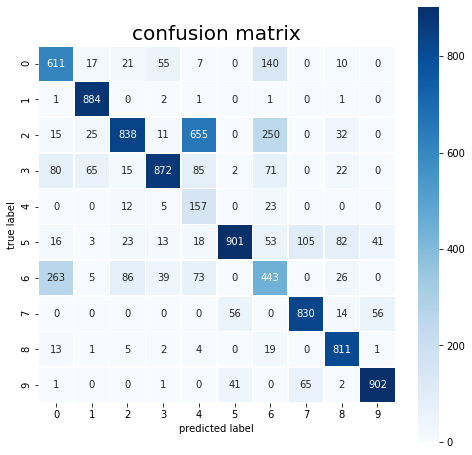

In [281]:
lr3 = LogisticRegression()
time_lr3, num_params_lr3 = train_lr_model(lr3,'l2') # l2_regularization
accuracy_trainset_lr3, accuracy_testset_lr3 = test_model(lr3)

In [282]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=0.01, momentum=0.5)

In [283]:
def train_cnn(model):
    max_epochs=6
    start=time.time()
    for epoch in range(max_epochs):  # loop over the dataset multiple times

        optimizer.zero_grad()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    end = time.time()
    print('Finished Training!')
    print('training time %.2f' % (end-start))
    num_params = sum(x.numel() for x in model.parameters())
    print("Total number of paramerters in cnn is {}".format(num_params))
    return (end-start), num_params

[1,  2000] loss: 0.885
[1,  4000] loss: 0.575
[1,  6000] loss: 0.493
[1,  8000] loss: 0.445
[1, 10000] loss: 0.418
[1, 12000] loss: 0.404
[1, 14000] loss: 0.380
[2,  2000] loss: 0.356
[2,  4000] loss: 0.357
[2,  6000] loss: 0.354
[2,  8000] loss: 0.339
[2, 10000] loss: 0.334
[2, 12000] loss: 0.336
[2, 14000] loss: 0.325
[3,  2000] loss: 0.310
[3,  4000] loss: 0.314
[3,  6000] loss: 0.316
[3,  8000] loss: 0.301
[3, 10000] loss: 0.302
[3, 12000] loss: 0.303
[3, 14000] loss: 0.296
[4,  2000] loss: 0.283
[4,  4000] loss: 0.288
[4,  6000] loss: 0.294
[4,  8000] loss: 0.285
[4, 10000] loss: 0.286
[4, 12000] loss: 0.281
[4, 14000] loss: 0.281
[5,  2000] loss: 0.267
[5,  4000] loss: 0.274
[5,  6000] loss: 0.273
[5,  8000] loss: 0.268
[5, 10000] loss: 0.270
[5, 12000] loss: 0.266
[5, 14000] loss: 0.268
[6,  2000] loss: 0.249
[6,  4000] loss: 0.259
[6,  6000] loss: 0.267
[6,  8000] loss: 0.258
[6, 10000] loss: 0.262
[6, 12000] loss: 0.263
[6, 14000] loss: 0.256
Finished Training!
training time 2

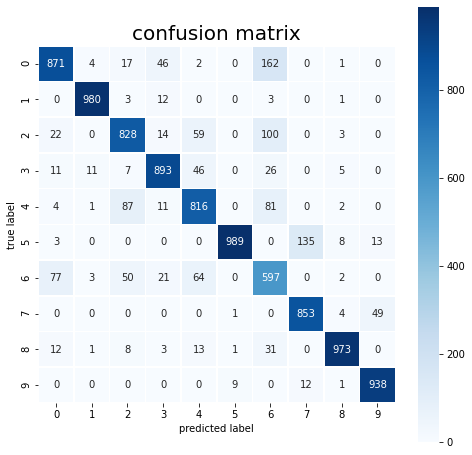

In [284]:
time_cnn1, num_params_cnn1 = train_cnn(myCNN)
accuracy_trainset_cnn1, accuracy_testset_cnn1 = test_model(myCNN)

In [288]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 20)
        self.fc5 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

myCNN2 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN2.parameters(), lr=0.01, momentum=0.5)

In [289]:
time_cnn2, num_params_cnn2 = train_cnn(myCNN2)

[1,  2000] loss: 1.927
[1,  4000] loss: 0.817
[1,  6000] loss: 0.621
[1,  8000] loss: 0.541
[1, 10000] loss: 0.501
[1, 12000] loss: 0.470
[1, 14000] loss: 0.441
[2,  2000] loss: 0.410
[2,  4000] loss: 0.404
[2,  6000] loss: 0.381
[2,  8000] loss: 0.371
[2, 10000] loss: 0.360
[2, 12000] loss: 0.361
[2, 14000] loss: 0.348
[3,  2000] loss: 0.330
[3,  4000] loss: 0.340
[3,  6000] loss: 0.325
[3,  8000] loss: 0.320
[3, 10000] loss: 0.319
[3, 12000] loss: 0.317
[3, 14000] loss: 0.313
[4,  2000] loss: 0.296
[4,  4000] loss: 0.307
[4,  6000] loss: 0.291
[4,  8000] loss: 0.288
[4, 10000] loss: 0.293
[4, 12000] loss: 0.288
[4, 14000] loss: 0.285
[5,  2000] loss: 0.271
[5,  4000] loss: 0.283
[5,  6000] loss: 0.276
[5,  8000] loss: 0.275
[5, 10000] loss: 0.278
[5, 12000] loss: 0.271
[5, 14000] loss: 0.280
[6,  2000] loss: 0.262
[6,  4000] loss: 0.269
[6,  6000] loss: 0.263
[6,  8000] loss: 0.253
[6, 10000] loss: 0.260
[6, 12000] loss: 0.253
[6, 14000] loss: 0.255
Finished Training!
training time 2

accuracy of the model on training dataset 90.31
accuracy of the model on test dataset 88.07


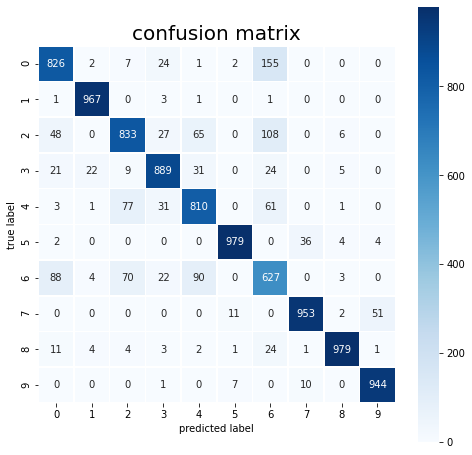

In [290]:
accuracy_trainset_cnn2, accuracy_testset_cnn2 = test_model(myCNN2)

In [291]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10,15, 5)
        self.conv4 = nn.Conv2d(15,20, 5)
        self.conv5 = nn.Conv2d(20,25, 5)
        self.fc1 = nn.Linear(25*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 25*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

myCNN3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN3.parameters(), lr=0.01, momentum=0.5)

In [292]:
time_cnn3, num_params_cnn3 = train_cnn(myCNN3)

[1,  2000] loss: 1.330
[1,  4000] loss: 0.778
[1,  6000] loss: 0.693
[1,  8000] loss: 0.611
[1, 10000] loss: 0.575
[1, 12000] loss: 0.547
[1, 14000] loss: 0.510
[2,  2000] loss: 0.488
[2,  4000] loss: 0.479
[2,  6000] loss: 0.463
[2,  8000] loss: 0.436
[2, 10000] loss: 0.452
[2, 12000] loss: 0.433
[2, 14000] loss: 0.425
[3,  2000] loss: 0.421
[3,  4000] loss: 0.409
[3,  6000] loss: 0.408
[3,  8000] loss: 0.388
[3, 10000] loss: 0.381
[3, 12000] loss: 0.382
[3, 14000] loss: 0.382
[4,  2000] loss: 0.370
[4,  4000] loss: 0.373
[4,  6000] loss: 0.380
[4,  8000] loss: 0.362
[4, 10000] loss: 0.350
[4, 12000] loss: 0.366
[4, 14000] loss: 0.353
[5,  2000] loss: 0.359
[5,  4000] loss: 0.355
[5,  6000] loss: 0.360
[5,  8000] loss: 0.347
[5, 10000] loss: 0.337
[5, 12000] loss: 0.342
[5, 14000] loss: 0.337
[6,  2000] loss: 0.358
[6,  4000] loss: 0.357
[6,  6000] loss: 0.339
[6,  8000] loss: 0.324
[6, 10000] loss: 0.318
[6, 12000] loss: 0.326
[6, 14000] loss: 0.339
Finished Training!
training time 4

accuracy of the model on training dataset 88.69
accuracy of the model on test dataset 87.07


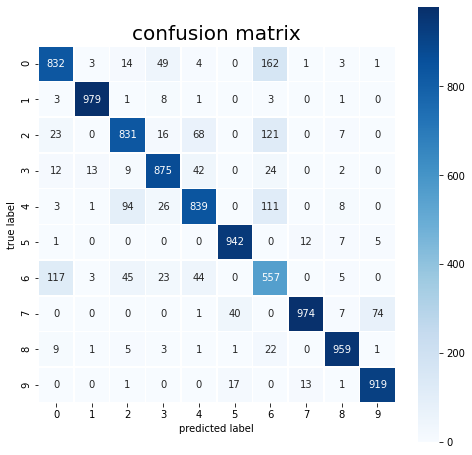

In [293]:
accuracy_trainset_cnn3, accuracy_testset_cnn3 = test_model(myCNN3)